# Imports & Downloads

In [ ]:
# useful libs
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image 

In [ ]:
# tensorflow libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers, regularizers
from keras.preprocessing import image
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

In [ ]:
# scikit libs
from sklearn.model_selection import train_test_split

# Data Loading

In [ ]:
def get_required_files():
  """
  Download required files from the given urls
  """
  
  if "lfwa.zip" not in os.listdir():
    print("Donwloading lfwa.zip...")
    !gdown --id 1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp
    
  if "lfw2" not in os.listdir():
    print("Unzipping lfwa.zip into lfw2...")
    !unzip lfwa.zip
 
  if "pairsDevTrain.txt" not in os.listdir():
    print("Donwloading pairsDevTrain.txt ...")
    !wget http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt    
  
  if "pairsDevTest.txt" not in os.listdir():
    print("Donwloading pairsDevTest.txt ...")
    !wget http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt

get_required_files()

In [ ]:
def get_image_name(face_folder_path, image_index):
  """
  Return the required image name according to the folder path and the index of the image.
  """
  for name in os.listdir(face_folder_path):
    if name.endswith(f"_{image_index.zfill(4)}.jpg"): # fill index with zeros, i,e  1 -> 0001 
      return name

In [ ]:
def load_data(txt_path, images_path):
  """
  Load data into arrays - X represting pairs of images, y represting the labels of the pairs - 1 for same person, 0 for different person.
  """
  X, y = [], []
  train_file = open(txt_path, "r")
  num_of_samples_per_label = 0

  # iterate over file rows 
  for index, line in enumerate(train_file):

    # first line says how many pairs from each label = num_of_samples_per_label
    if index == 0:
      num_of_samples_per_label = int(line)
    
    # next lines represent pairs from label 1 until num_of_samples_per_label
    elif index <= num_of_samples_per_label:
      
      line = line.strip().split("\t") # split line into -> person name, face index, face index
      
      face_folder_path = os.path.join(images_path, line[0])
      
      # get names of the required images
      first_image_name =  get_image_name(face_folder_path, line[1]) 
      second_image_name = get_image_name(face_folder_path, line[2])
      
      # check if the returned names aren't none
      if first_image_name is None or second_image_name is None:
        print("None pair. Continue")
        continue

      # concateate face folder and image path in order to load those images
      first_image_path = os.path.join(face_folder_path, first_image_name)
      second_image_path = os.path.join(face_folder_path, second_image_name)
      
      # load images into objects
      first_image = tf.image.central_crop(image.img_to_array(image.load_img(first_image_path, color_mode='grayscale')), 0.5)
      second_image = tf.image.central_crop(image.img_to_array(image.load_img(second_image_path, color_mode='grayscale')), 0.5)
      
      # make pair of those two images and apppend class 1 into y array
      pair_face = np.stack([first_image, second_image])
      X.append(pair_face)
      y.append(1)
    
    # next lines represent pairs from label 0
    else:
      line = line.strip().split("\t") # split line into -> person name, face index, person name, face index
      
      first_face_folder_path = os.path.join(images_path, line[0])
      second_face_folder_path = os.path.join(images_path, line[2])
      
      first_image_name = get_image_name(first_face_folder_path, line[1])
      second_image_name = get_image_name(second_face_folder_path, line[3])
      
      if first_image_name is None or second_image_name is None:
        print("One of the pair is None. Continue")
        continue

      first_image_path = os.path.join( first_face_folder_path, first_image_name)
      second_image_path = os.path.join( second_face_folder_path, second_image_name)
      
      first_image = tf.image.central_crop(image.img_to_array( image.load_img( first_image_path, color_mode='grayscale')), 0.5)
      second_image = tf.image.central_crop(image.img_to_array( image.load_img( second_image_path, color_mode='grayscale')), 0.5)

      pair_face = np.stack([first_image, second_image])
      X.append(pair_face)
      y.append(0)
      
  return np.stack(X), np.vstack(y)

In [ ]:
# run data loading 
train_file = "pairsDevTrain.txt"
test_file = "pairsDevTest.txt"
images_folder = "lfw2/lfw2"

X_train, Y_train = load_data(train_file, images_folder) 
X_test, Y_test = load_data(test_file, images_folder)

# Exploration

In [ ]:
# exploration of files
print(f"Num of different people: {len(os.listdir(images_folder))}")

Num of different people: 5749


In [ ]:
# Exploration of train set
print(f"Num of total train samples: {len(Y_train)}")
print(f"Num of positive labels in train == 1: {np.count_nonzero(Y_train == 1)}")
print(f"Num of negative labels in train == 0: {np.count_nonzero(Y_train == 0)}")

Num of total train samples: 2200
Num of positive labels in train == 1: 1100
Num of negative labels in train == 0: 1100


In [ ]:
# Exploration of test set
print(f"Num of total test samples: {len(Y_test)}")
print(f"Num of positive labels in test == 1: {np.count_nonzero(Y_test == 1)}")
print(f"Num of negative labels in test == 0: {np.count_nonzero(Y_test == 0)}")

Num of total test samples: 1000
Num of positive labels in test == 1: 500
Num of negative labels in test == 0: 500


# Preprocessing

In [ ]:
def normalization(data):
  """
  Normalize data between 0-1
  """
  return data / 255.0

In [ ]:
# run normalization
X_train = normalization(X_train)
X_test = normalization(X_test)

# Split Train & Validation

In [ ]:
def split_train_val(X_train, Y_train):
  """
  split train data into two balanced sets of train and validaion, while train size is 85%.
  """
  x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, train_size=0.85, shuffle=True, random_state=42, stratify=Y_train)
  return (x_train, y_train), (x_val, y_val)

In [ ]:
# run spliting
(x_train, y_train), (x_val, y_val) = split_train_val(X_train, Y_train)

# Add flipped images

In [ ]:
def add_flipped_images(x_train, y_train):
  """
  Iterate over all training examples, flip one of the pair images, and add it into the train set.
  """
  x_train_flip = list(x_train.copy())
  y_train_flip = list(y_train.copy())

  for index, pair in enumerate(x_train):
    first_fliiped_image = tf.image.flip_left_right(pair[0]) # flip image 
    second_image = pair[1] # add second image as is
    
    pair_face = np.stack([first_fliiped_image, second_image])
    x_train_flip.append(pair_face)
    y_train_flip.append(y_train[index])
  
  return np.stack(x_train_flip), np.vstack(y_train_flip)

In [ ]:
# run flipping 
x_train_flip, y_train_flip = add_flipped_images(x_train, y_train)

# Data Preparation

In [ ]:
def split_pairs_into_two_lists(data):
  """
  split pairs array into two arrays of the first images and the second images.
  """
  first_pairs, second_pairs = zip(*data)
  first_pairs_stack = np.stack(first_pairs)
  second_pairs_stack = np.stack(second_pairs)
  return first_pairs_stack, second_pairs_stack

In [ ]:
# run splitting between pairs
# first_train_pairs, second_train_pairs = split_pairs_into_two_lists(x_train)
first_train_pairs, second_train_pairs = split_pairs_into_two_lists(x_train_flip)
first_val_pairs, second_val_pairs = split_pairs_into_two_lists(x_val)
first_test_pairs, second_test_pairs = split_pairs_into_two_lists(X_test)

In [ ]:
# Explore train set after spliting 
print(f"Num of total train samples: {len(y_train_flip)}")
print(f"Num of positive labels in train == 1: {np.count_nonzero(y_train_flip == 1)}")
print(f"Num of negative labels in train == 0: {np.count_nonzero(y_train_flip == 0)}")

Num of total train samples: 3740
Num of positive labels in train == 1: 1870
Num of negative labels in train == 0: 1870


In [ ]:
# Explore val set after spliting 
print(f"Num of total train samples: {len(y_val)}")
print(f"Num of positive labels in train == 1: {np.count_nonzero(y_val == 1)}")
print(f"Num of negative labels in train == 0: {np.count_nonzero(y_val == 0)}")

Num of total train samples: 330
Num of positive labels in train == 1: 165
Num of negative labels in train == 0: 165


# Test

In [ ]:
def build_model(input_shape):
  first_input, second_input = keras.Input(shape=input_shape), keras.Input(shape=input_shape)
  kernel_initializer_conv = initializers.RandomNormal(mean=0.0, stddev=0.001)
  bias_initializer = initializers.RandomNormal(mean=0.5, stddev=0.001)
  kernel_initializer_dense = initializers.RandomNormal(mean=0.0, stddev=0.2)
  # kernel_regularizer = regularizers.l2(l2=0.0001)
  
  # Best convolutional architecture selected for verification task according to Gregory Koch et al. paper
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=64,kernel_size=(10,10), activation='relu', kernel_initializer=kernel_initializer_conv, bias_initializer=bias_initializer))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(filters=128,kernel_size=(7,7), activation='relu', kernel_initializer=kernel_initializer_conv, bias_initializer=bias_initializer))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(filters=128,kernel_size=(4,4), activation='relu', kernel_initializer=kernel_initializer_conv, bias_initializer=bias_initializer))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(filters=256,kernel_size=(4,4), activation='relu', kernel_initializer=kernel_initializer_conv, bias_initializer=bias_initializer))
  model.add(layers.Flatten())
  model.add(layers.Dense(units=4096, activation='sigmoid' , kernel_initializer=kernel_initializer_dense, bias_initializer=bias_initializer))
  
  # Add a customized layer to compute the absolute difference between the encodings
  first_input_encode = model(first_input)
  second_input_encode = model(second_input)
  distance_layer = layers.Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([first_input_encode, second_input_encode])

  # Add prediction layer
  prediction_layer = layers.Dense(1,activation='sigmoid', kernel_initializer=kernel_initializer_dense, bias_initializer=bias_initializer)(distance_layer)
  siamese_model = keras.Model(inputs=[first_input,second_input], outputs=prediction_layer)

  # Add a dense layer with a sigmoid unit to generate the similarity score
  siamese_model.summary()
  return siamese_model

# Implementation

In [ ]:
def build_model(input_shape):
  """
  Builds CNN siamese network
  """
  
  # the model gets two inputs of size input_shape
  first_input, second_input = keras.Input(shape=input_shape), keras.Input(shape=input_shape) 

  # Best convolutional architecture selected for verification task according to Gregory Koch et al. paper
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=64, kernel_size=(10,10), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2)))

  model.add(layers.Conv2D(filters=128, kernel_size=(7,7), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2)))

  model.add(layers.Conv2D(filters=128, kernel_size=(4,4), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2)))

  model.add(layers.Conv2D(filters=256, kernel_size=(4,4), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())

  model.add(layers.Dense(units=4096, activation='sigmoid' ))

  # Add a customized layer to compute the absolute difference between the encodings
  first_input_encode = model(first_input)
  second_input_encode = model(second_input)
  distance_layer = layers.Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([first_input_encode, second_input_encode])

  # Add prediction layer
  prediction_layer = layers.Dense(1,activation='sigmoid')(distance_layer)
  siamese_model = keras.Model(inputs=[first_input,second_input], outputs=prediction_layer)

  # Add a dense layer with a sigmoid unit to generate the similarity score
  siamese_model.summary()
  return siamese_model

In [ ]:
def plot_model_history(history):
  """
  Plot accuracy and loss graphs of thr train and validation training process
  """

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train' , 'val'], loc='upper left')
  plt.show()
  
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 126, 126, 1) 0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 126, 126, 1) 0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 4096)         68310080    input_23[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 4096)         0           sequential_11[0][0]       

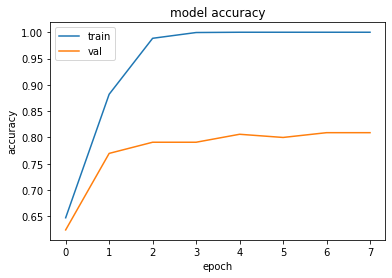

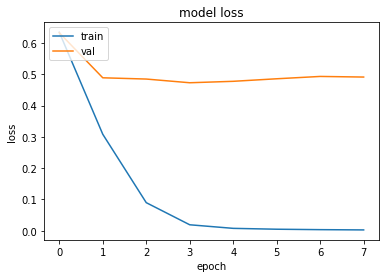

Evaluate model on validation set...
Validation Loss:  0.49, Validation Accuracy: 80.91
Evaluate model on test set...
Test Loss:  0.57, Test Accuracy: 78.00


In [ ]:
input_shape = first_train_pairs[0].shape # shape of one example, same for all examples

# build siamese model with input shape
model = build_model(input_shape)

# plot model arcitechture
plot_model(model,show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='LR')

# compile model with adam optimizer
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Early stopping criterion
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=False)

# train model on train set and evaluate its performance on the validation set
start_time = time.time()
print("Model training...\n" + "="*98)
history = model.fit(x=[first_train_pairs, second_train_pairs], y=y_train_flip, batch_size=16, epochs=40, verbose=1, validation_data=([first_val_pairs, second_val_pairs], y_val), callbacks=[es])
print(f"Convergence time is :{time.time() - start_time}")

# plot the loss on the training set throughout the training process 
plot_model_history(history)

# evaluate model on val set
print("Evaluate model on validation set...\n" + "="*98)
val_loss, val_accuracy = model.evaluate(x=[first_val_pairs, second_val_pairs], y=y_val, verbose=0)
print(f'Validation Loss:  %.2f, Validation Accuracy: %.2f' % (val_loss, val_accuracy * 100))

# evaluate model on test set
print("Evaluate model on test set...\n" + "="*98)
test_loss, test_accuracy = model.evaluate(x=[first_test_pairs, second_test_pairs], y=Y_test , verbose=0)
print(f'Test Loss:  %.2f, Test Accuracy: %.2f' % (test_loss, test_accuracy * 100))

# Analyze results

In [ ]:
# examples of accurate and misclassifications 
prediction = model.predict(x=[first_test_pairs, second_test_pairs]) # predict labels
prediction[prediction > 0.5] = 1 # if prediction greater than 0.5 -> label equals 1
prediction[prediction <= 0.5] = 0 # if prediction lower or eqaul than 0.5 -> label equals 0

# get indices of misclassifications and 3 examples 
mis_indices = np.where(prediction != Y_test)
misclassified_pair_1 = (first_test_pairs[mis_indices[0][0]], second_test_pairs[mis_indices[0][0]])
misclassified_pair_2 = (first_test_pairs[mis_indices[0][1]], second_test_pairs[mis_indices[0][1]])
misclassified_pair_3 = (first_test_pairs[mis_indices[0][2]], second_test_pairs[mis_indices[0][2]])

# get indices of correct classifications and 3 examples 
correct_indices = np.where(prediction == Y_test)
correct_pair_1 = (first_test_pairs[correct_indices[0][0]], second_test_pairs[correct_indices[0][0]])
correct_pair_2 = (first_test_pairs[correct_indices[0][1]], second_test_pairs[correct_indices[0][1]])
correct_pair_3 = (first_test_pairs[correct_indices[0][2]], second_test_pairs[correct_indices[0][2]])

misclassified pair 1:


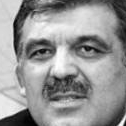

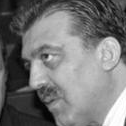

misclassified pair 2:


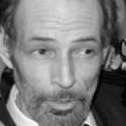

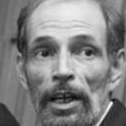

misclassified pair 3:


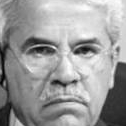

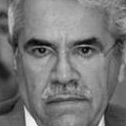

In [ ]:
# plot misclassified images
print("misclassified pair 1:")
display(image.array_to_img(misclassified_pair_1[0]))
display(image.array_to_img(misclassified_pair_1[1]))

print("misclassified pair 2:")
display(image.array_to_img(misclassified_pair_2[0]))
display(image.array_to_img(misclassified_pair_2[1]))

print("misclassified pair 3:")
display(image.array_to_img(misclassified_pair_3[0]))
display(image.array_to_img(misclassified_pair_3[1]))

correct classification pair 1:


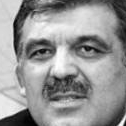

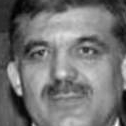

correct classification pair 2:


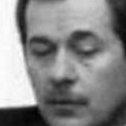

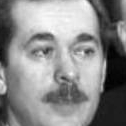

correct classification pair 3:


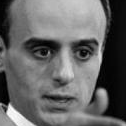

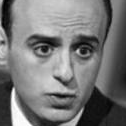

In [ ]:
# plot correct classification images
print("correct classification pair 1:")
display(image.array_to_img(correct_pair_1[0]))
display(image.array_to_img(correct_pair_1[1]))

print("correct classification pair 2:")
display(image.array_to_img(correct_pair_2[0]))
display(image.array_to_img(correct_pair_2[1]))

print("correct classification pair 3:")
display(image.array_to_img(correct_pair_3[0]))
display(image.array_to_img(correct_pair_3[1]))